In [12]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt


In [13]:
# for potential switch
def u_lj_sc_shift(r, lam, sigma, epsilon, vdw_switch, vdw, alpha, disp_corr=False):
    
    # Soft core correction: calc r_A and r_B
    r_A = ((alpha * sigma**6 * lam + r**6)**(1/6))
    r_B = ((alpha * sigma**6 * (1 - lam) + r**6)**(1/6))

    # Hard core vdw 
    V_A = 4 * epsilon * ((sigma / r_A)**12 - (sigma / r_A)**6)
    V_B = 4 * epsilon * ((sigma / r_B)**12 - (sigma / r_B)**6)

    # Potential switch function
    if r < vdw_switch:
        S_v = 1
    elif vdw_switch <= r < vdw:
        x = (r - vdw_switch) / (vdw - vdw_switch)
        S_v = 1 - 10 * x**3 + 15 * x**4 - 6 * x**5
    else:
        S_v = 0

    # Compute the total potential
    potential = (1 - lam) * V_A + lam * V_B
    potential *= S_v

    # Dispersion correction
    if disp_corr and r >= vdw_switch:
        disp_corr = -8 * np.pi * epsilon * (sigma**6) / (3 * vdw**3)
        potential -= disp_corr

    return potential




In [14]:
# potential switch
def u_lj_sc_shift_deriv(r, lam, sigma, epsilon, vdw_switch, vdw, alpha, disp_corr=False):
     # Soft core correction: calc r_A and r_B
    r_A = ((alpha * sigma**6 * lam + r**6)**(1/6))
    r_B = ((alpha * sigma**6 * (1 - lam) + r**6)**(1/6))

    # Hard core vdw [potentials]
    V_A = 4 * epsilon * ((sigma / r_A)**12 - (sigma / r_A)**6)
    V_B = 4 * epsilon * ((sigma / r_B)**12 - (sigma / r_B)**6)

    # Derivative of the potential
    dU_dlam = V_B - V_A

    # Optional dispersion correction
    # Dispersion correction
    if disp_corr and r >= vdw_switch:
        disp_corr = -8 * np.pi * epsilon * (sigma**6) / (3 * vdw**3)
        dU_dlam -= disp_corr
        
    return dU_dlam


In [15]:
#potential switch
def avg_derivative(sigma, epsilon, alpha, lam, rho, k_B, T, vdw, vdw_switch, p=1, disp_corr=False):
    def integrand(r):
        # Calculate the derivative of the potential
        dU_dlam = u_lj_sc_shift_deriv(r, lam, sigma, epsilon, vdw_switch, vdw, alpha, disp_corr)
        
        # Soft core correction: calc r_A and r_B
        r_A = ((alpha * sigma**6 * lam + r**6)**(1/6))
        r_B = ((alpha * sigma**6 * (1 - lam) + r**6)**(1/6))

        # Hard core vdw [potentials]
        V_A = 4 * epsilon * ((sigma / r_A)**12 - (sigma / r_A)**6)
        V_B = 4 * epsilon * ((sigma / r_B)**12 - (sigma / r_B)**6)

        # Potential
        U_r_lam = (1 - lam) * V_A + lam * V_B

        # RDF
        g_0_r = rho * np.exp(-(1 / (k_B * T)) * U_r_lam)

        return dU_dlam * g_0_r * 4 * np.pi * r**2

    # Integrate from 0 to vdw_switch
    integral1, _ = spi.quad(integrand, 0, vdw_switch)

    def disp_integral(r):
        return u_lj_sc_shift_deriv(r, lam, sigma, epsilon, vdw_switch, vdw, alpha, disp_corr=True) * 4 * np.pi * r**2

    # Integrate from vdw_switch to infinity (dispersion correction part)
    integral2, _ = spi.quad(disp_integral, vdw_switch, np.inf)

    # Combine the integrals
    total_integral = integral1 + integral2 if disp_corr else integral1
    
    return total_integral


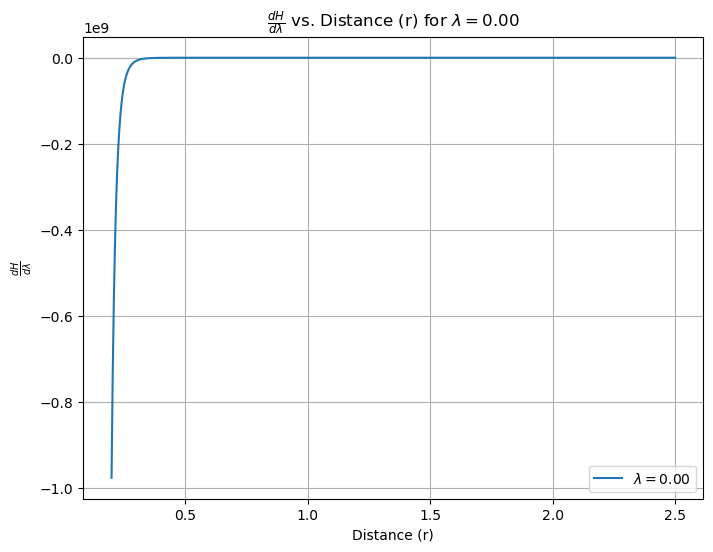

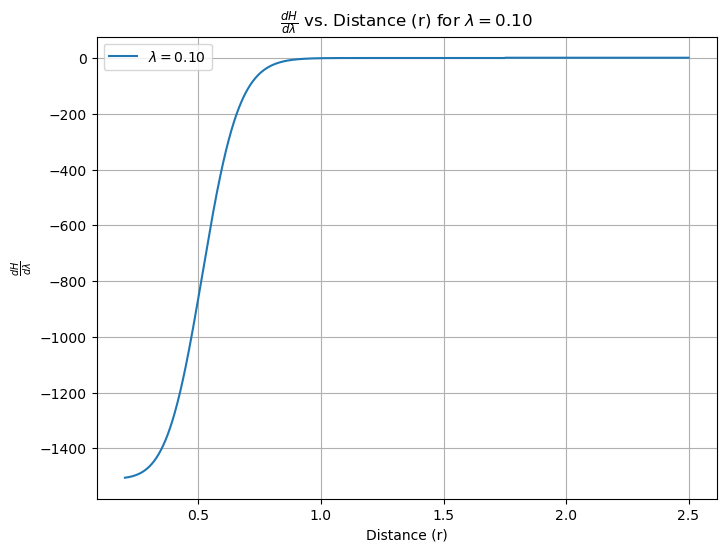

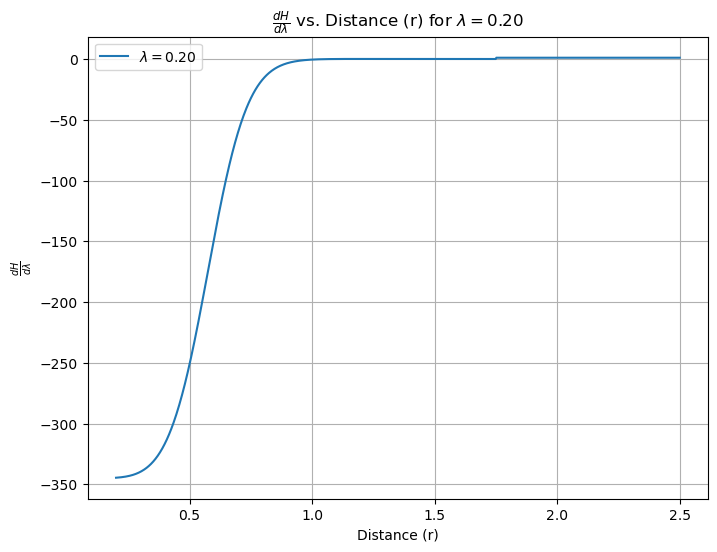

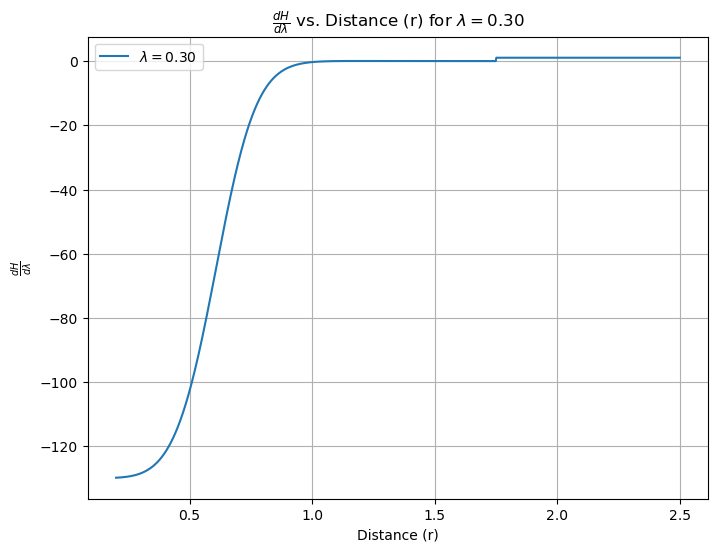

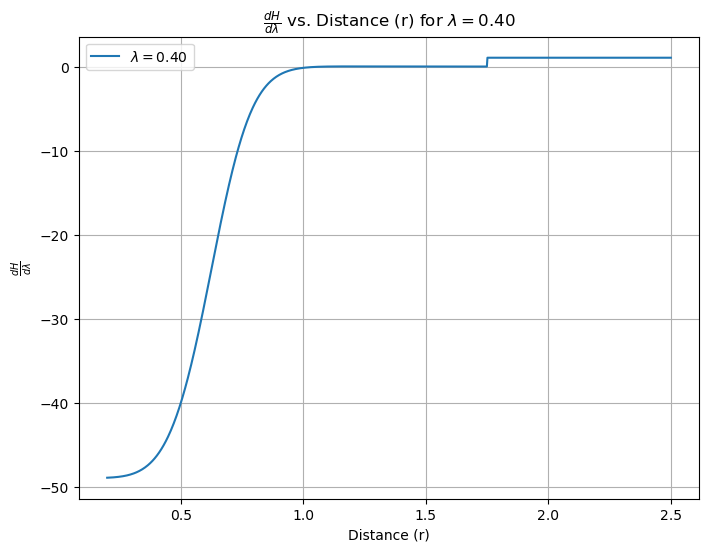

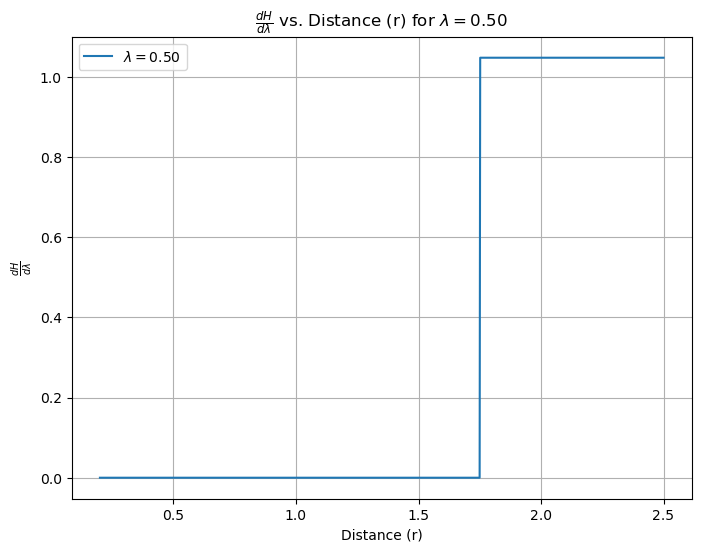

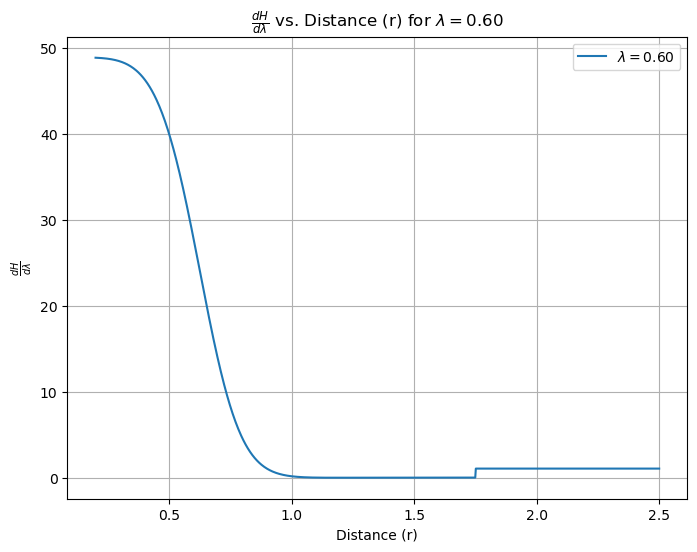

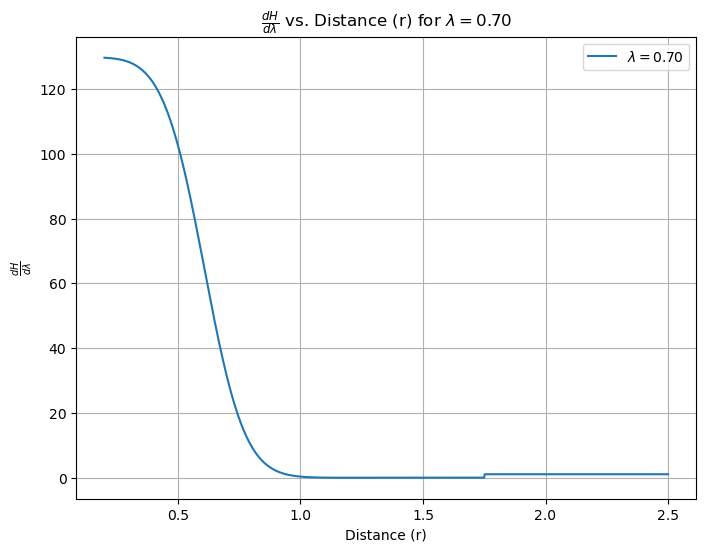

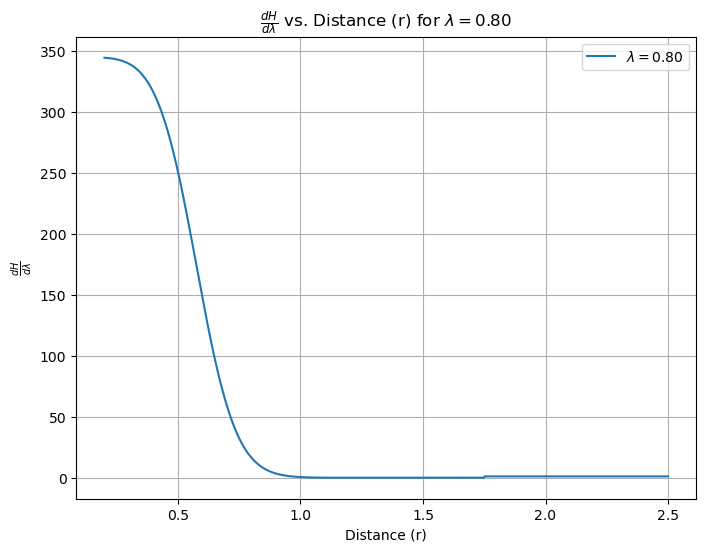

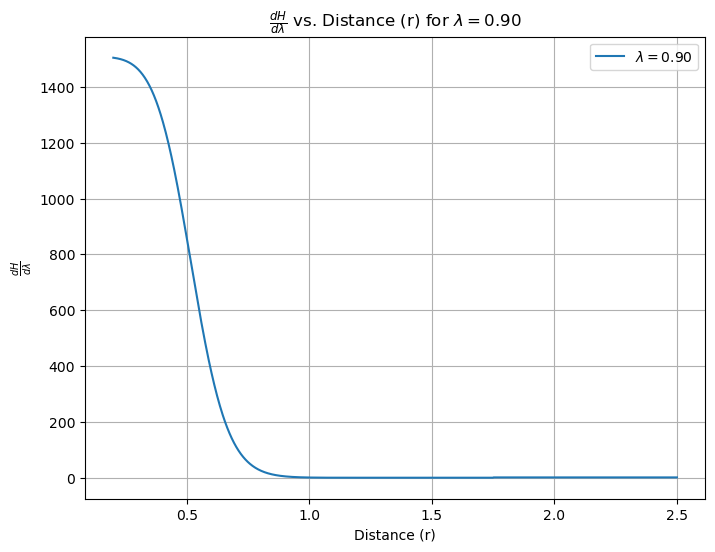

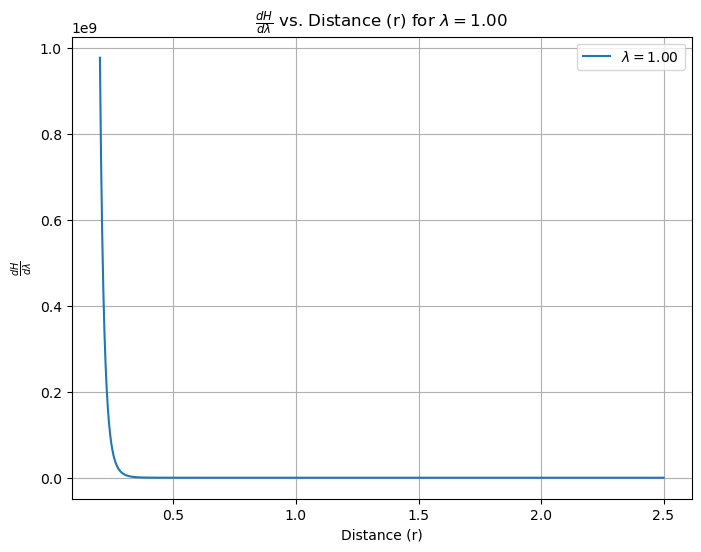

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
sigma = 1.0
epsilon = 1.0
alpha = 0.5
vdw_switch = 1.75
vdw = 2.0

# Define r values
r_values = np.linspace(0.2, 2.5, 1000)

# Define lambda values
lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Adjust the number of lambda values as needed

# Loop over each lambda value to plot dH/dλ on separate graphs
for lam in lambda_values:
    dhdl_r = [u_lj_sc_shift_deriv(r, lam, sigma, epsilon, vdw_switch, vdw, alpha, disp_corr=True) for r in r_values]
    plt.figure(figsize=(8, 6))
    plt.plot(r_values, dhdl_r, label=r'$\lambda = {:.2f}$'.format(lam))
    
    plt.xlabel('Distance (r)')
    plt.ylabel(r'$\frac{{dH}}{{d\lambda}}$')
    plt.title(r'$\frac{{dH}}{{d\lambda}}$ vs. Distance (r) for $\lambda = {:.2f}$'.format(lam))
    plt.legend()
    plt.grid(True)
    plt.show()



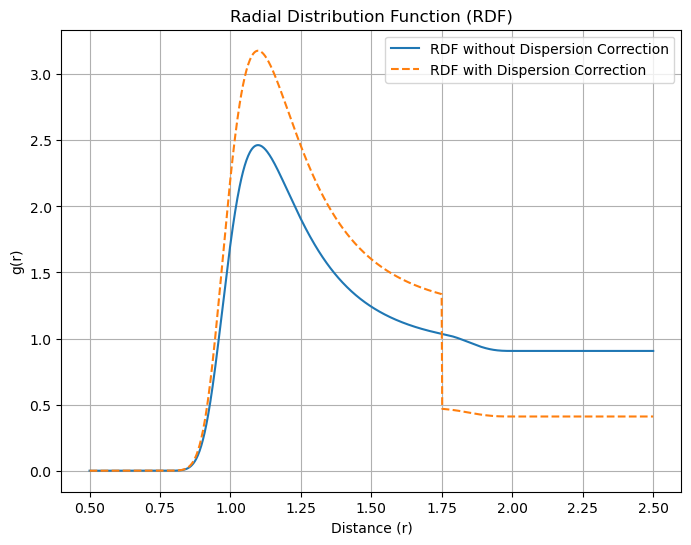

In [17]:

# Constants
sigma = 1.0
epsilon = 1.0
alpha = 0.5
lam = 0.5
rho = 1.0  # Density (number of particles per unit volume)
k_B = 1.0  # Boltzmann constant
T = 1.0    # Temperature
vdw_switch = 1.75
vdw = 2.0

# Function to compute RDF
def compute_rdf(r_values, lam, sigma, epsilon, vdw_switch, vdw, alpha, k_B, T, disp_corr=False):
    g_r = np.exp(-np.array([u_lj_sc_shift(r_i, lam, sigma, epsilon, vdw_switch, vdw, alpha, disp_corr) for r_i in r_values]) / (k_B * T))
    g_r /= np.mean(g_r)  # Normalize RDF
    return g_r

# Distance range for RDF calculation
r_values = np.linspace(0.5, 2.5, 1000)

# Calculate RDF without dispersion correction
g_r_no_corr = compute_rdf(r_values, lam, sigma, epsilon, vdw_switch, vdw, alpha, k_B, T, disp_corr=False)

# Calculate RDF with dispersion correction
g_r_with_corr = compute_rdf(r_values, lam, sigma, epsilon, vdw_switch, vdw, alpha, k_B, T, disp_corr=True)

# Plot RDFs
plt.figure(figsize=(8, 6))
plt.plot(r_values, g_r_no_corr, label='RDF without Dispersion Correction')
plt.plot(r_values, g_r_with_corr, label='RDF with Dispersion Correction', linestyle='--')
plt.xlabel('Distance (r)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF)')
plt.legend()
plt.grid(True)
plt.show()

